In [1]:
## Data preparation and cleaning
# importing required packages
import pyreadr
import numpy as np
import pandas as pd
import torch
import pickle
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\zhaoz\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import data and convert to python objects
# load Rdata object
rdata = pyreadr.read_r('det_dfs.Rdata')
# pull out separate dataframes, one with choice text, the other with numeric responses
df = rdata['df']
dfn = rdata['dfn']
# df.head()


# read in state labels
states = pd.read_csv('states.csv')
states['statepair'] = states['state1'] + '_' + states['state2']# construct state pair strings
# states.head()

# extract all the self ratings
ind_selfq1 = df.columns.get_loc('X1_Q12_1') # location of the first question
trans_self = df.iloc[:,list(range(ind_selfq1,(ind_selfq1+75)))]
print('shape of self-rating dataframe: ',trans_self.shape)
trans_self.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs

# extract all the specific target ratings
ind_targq1 = df.columns.get_loc('X1_Q9_1') # location of the first question
trans_targ = df.iloc[:,list(range(ind_targq1,(ind_targq1+75)))]
print('shape of target-rating dataframe: ', trans_targ.shape)
trans_targ.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs

# extract all the group level ratings
ind_avgq1 = df.columns.get_loc('X1_Q11_1') # location of the first question
trans_avg = df.iloc[:,list(range(ind_avgq1,(ind_avgq1+75)))]
print('shape of group-rating dataframe: ', trans_avg.shape)
trans_avg.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs


shape of self-rating dataframe:  (94, 75)
shape of target-rating dataframe:  (94, 75)
shape of group-rating dataframe:  (94, 75)


In [3]:
# reusable code for pre processing each of the three sets of ratings into pyro compatible format

# altering edge values to avoid rounding errors while sampling
def de_edge_raw(t):
    t[t == 0] = .0001
    t[t == 1] = .9999
    return t

def de_edge_norm(t):
    ## in the normed data there's no 1s
    # change 0 to .0001 and decrement the max value of the same row by .0001 
    # in order to make sure the row still sums to 1
    ind_zero = np.where(t == 0)
    t[ind_zero] += .0001
    ind_max = np.argmax(t,axis = 2)
    for i in np.arange(ind_zero[0].shape[0]):
        temp_max = ind_max[ind_zero[0][i],ind_zero[1][i]]
        t[ind_zero[0][i],ind_zero[1][i],temp_max] -= .0001
    return t

def data_transform(trans):
    # set the constant for converting probability to frequency
    freq_constant = 10000
    # indexing autotransition columns
    colnames = trans.columns.tolist()
    cnsplit = [p.split('_') for p in colnames]
    idx_autotransition = [p[0] == p[1] for p in cnsplit] # list of boolean, True = is autotransition
    
    # 1. normalizing with autotransitions included, one df for probability, one converted to frequency
    # initialize 2 dataframes
    t_norm_all = pd.DataFrame(columns=trans.columns, index = trans.index)
    t_norm_all_f =  pd.DataFrame(columns=trans.columns, index = trans.index)
    
    # normalize by row-sum every five columns, since the columns are already arranged by from-state in 5
    for i in range(0,trans.shape[1],5):
        dftemp = trans.iloc[:,i:(i+5)]
        dftemp_rowsum = dftemp.sum(axis = 1)
        normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
        t_norm_all.iloc[:,i:(i+5)] = normed_cols
        t_norm_all_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()
        
    # 2. two additional dataframes: normed with auto transition but don't contain them
    t_norm_all_noauto = t_norm_all.loc[:,[not t for t in idx_autotransition]]
    t_norm_all_noauto_f = t_norm_all_f.loc[:,[not t for t in idx_autotransition]]

    # 3. finally, normalizing without autotransitions, and also convert to frequency
    trans_noauto = trans.loc[:,[not t for t in idx_autotransition]]
    t_norm_noauto = pd.DataFrame(columns=trans_noauto.columns, index = trans_noauto.index)
    t_norm_noauto_f = pd.DataFrame(columns=trans_noauto.columns, index = trans_noauto.index)

    # normalize by row-sum every FOUR columns, grouped by from-state in 4 without autotransition
    for i in range(0,trans_noauto.shape[1],4):
        dftemp = trans_noauto.iloc[:,i:(i+4)]
        dftemp_rowsum = dftemp.sum(axis = 1)
        normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
        t_norm_noauto.iloc[:,i:(i+5)] = normed_cols
        t_norm_noauto_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()
        
    t_norm_all_3d = torch.tensor(np.stack([np.array(t_norm_all.iloc[i]).reshape(15,5) 
                                        for i in np.arange(t_norm_all.shape[0])]).astype('float32'))
    t_norm_noauto_3d = torch.tensor(np.stack([np.array(t_norm_noauto.iloc[i]).reshape(15,4) 
                                            for i in np.arange(t_norm_noauto.shape[0])]).astype('float32'))
    t_raw_all_3d = torch.tensor(np.stack([np.array(trans.iloc[i]).reshape(15,5) 
                                            for i in np.arange(trans.shape[0])]).astype('float32'))
    t_raw_noauto_3d = torch.tensor(np.stack([np.array(trans_noauto.iloc[i]).reshape(15,4) 
                                            for i in np.arange(trans_noauto.shape[0])]).astype('float32'))
    
    return de_edge_norm(t_norm_all_3d), de_edge_norm(t_norm_noauto_3d), de_edge_raw(t_raw_all_3d/100), de_edge_raw(t_raw_noauto_3d/100)
#     return t_norm_all_3d, t_norm_noauto_3d, de_edge(t_raw_all_3d/100), de_edge(t_raw_noauto_3d/100)


In [4]:
tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d = data_transform(trans_self)
ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d = data_transform(trans_targ)
tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d = data_transform(trans_avg)


C:\Users\zhaoz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
C:\Users\zhaoz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [5]:
# # save data to file for easy import
# with open('tomtom_data_preprocessed.pkl', 'wb') as f:  
#     pickle.dump([tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
#                  ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
#                  tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d], f)


In [6]:
# inspect the "spread" of target vs group ratings using pairwise correlation between subjects
# getting pairwise correlations
trans_self_corbtsub = trans_self.transpose().corr()
trans_targ_corbtsub = trans_targ.transpose().corr()
trans_avg_corbtsub = trans_avg.transpose().corr()

# get the mean pairwise correlation for each of the three sets of correlations
def mean_pairwise_corr(corbtsub):
    corbtsub = np.array(corbtsub)
    corbtsub_flat = corbtsub[np.tril_indices(corbtsub.shape[0],-1)] # gett lower triangle and flatten
#     print(corbtsub_flat.shape)
    return corbtsub_flat, np.nanmean(corbtsub_flat)

trans_self_pairwiseflat, trans_self_meanpairwise = mean_pairwise_corr(trans_self_corbtsub)
trans_targ_pairwiseflat, trans_targ_meanpairwise = mean_pairwise_corr(trans_targ_corbtsub)
trans_avg_pairwiseflat, trans_avg_meanpairwise = mean_pairwise_corr(trans_avg_corbtsub)

print('The spread of self ratings: ', trans_self_meanpairwise)
print('The spread of target ratings: ', trans_targ_meanpairwise)
print('The spread of group ratings: ', trans_avg_meanpairwise)

scipy.stats.ttest_rel(trans_targ_pairwiseflat,trans_avg_pairwiseflat, nan_policy='omit')

The spread of self ratings:  0.5710433236550672
The spread of target ratings:  0.5042138201358816
The spread of group ratings:  0.6135978109836753


Ttest_relResult(statistic=-44.555126397363594, pvalue=0.0)

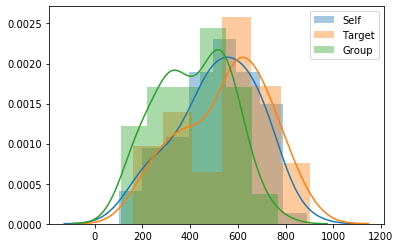

In [7]:
# Additional way to look at the spread of specific vs group: looking at the variance for each of the items
# the graph shows less spread at the item level for group ratings than for self or target specific ratings.
itemvar_trans_self = trans_self.var(axis = 0)
itemvar_trans_targ = trans_targ.var(axis = 0)
itemvar_trans_avg = trans_avg.var(axis = 0)

sns.distplot(itemvar_trans_self, label='Self')
sns.distplot(itemvar_trans_targ, label='Target')
sns.distplot(itemvar_trans_avg, label='Group')
plt.legend()
plt.show()